## Cat and Dog Image Classification

In [20]:
# Importing libraries

import numpy as np
import pandas as pd

from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random, os
from PIL import Image

In [21]:
# Setting constants

FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3 # RGB color

#### Preparing Data

In [22]:
filenames = os.listdir("./Data/train")
categories = []

for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [23]:
df.head()

,filename,category
0,cat.2873.jpg,0
1,dog.4872.jpg,1
2,dog.6792.jpg,1
3,dog.9448.jpg,1
4,cat.171.jpg,0


In [24]:
df.tail()

,filename,category
24995,dog.6446.jpg,1
24996,cat.6764.jpg,0
24997,cat.2386.jpg,0
24998,cat.11539.jpg,0
24999,cat.7431.jpg,0


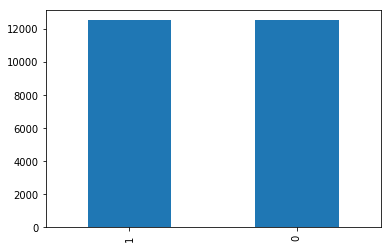

In [25]:
df['category'].value_counts().plot.bar()

#### Seeing sample image

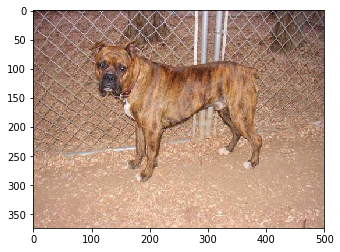

In [26]:
sample = random.choice(filenames)
image = load_img('./Data/train/'+sample)
plt.imshow(image)

#### Building Model

In [27]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

In [28]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_5 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_6 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 30, 30, 64)        0         
__________

#### Callbacks

In [29]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [30]:
# To prevent over fitting we will stop the learning after 10 epochs and val_loss value not decreased
earlystop = EarlyStopping(patience=10)

# We will reduce the learning rate when then accuracy not increase for 2 steps
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]

#### Prepare Test and Train Data

In [31]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)                # Removing the index values
validate_df = validate_df.reset_index(drop=True)
train_df.head()

,filename,category
0,cat.10228.jpg,0
1,dog.6686.jpg,1
2,cat.8631.jpg,0
3,dog.11327.jpg,1
4,dog.7410.jpg,1


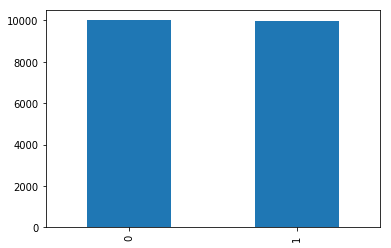

In [32]:
train_df['category'].value_counts().plot.bar()

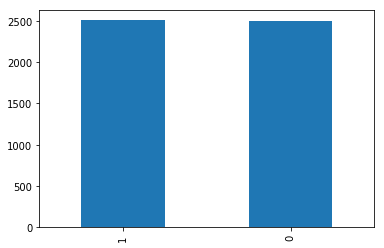

In [33]:
validate_df['category'].value_counts().plot.bar()

In [37]:
total_train = train_df.shape[0]              # train_df.shape- Retrun (row, column), here we take no. of rows
total_validate = validate_df.shape[0]
batch_size=15

#### Training Generator

In [40]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_df['category'] = train_df['category'].astype('str')

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "./Data/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=batch_size
)

Found 20000 images belonging to 2 classes.


#### Validate Generator

In [43]:
validation_datagen = ImageDataGenerator(rescale=1./255)

validate_df['category'] = validate_df['category'].astype('str')

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "./Data/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=batch_size
)

Found 5000 images belonging to 2 classes.


In [44]:
train_df.sample(n=1).head()

,filename,category
18280,cat.5609.jpg,0


#### Fit Model

In [45]:
epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
1333/1333 [==============================] - 1834s 1s/step - loss: 0.7030 - acc: 0.6445 - val_loss: 0.5238 - val_acc: 0.7389
Epoch 2/50
1333/1333 [==============================] - 1907s 1s/step - loss: 0.5300 - acc: 0.7387 - val_loss: 0.5878 - val_acc: 0.6977
Epoch 3/50
1333/1333 [==============================] - 1973s 1s/step - loss: 0.4834 - acc: 0.7671 - val_loss: 0.4460 - val_acc: 0.7960
Epoch 4/50
1333/1333 [==============================] - 1965s 1s/step - loss: 0.4490 - acc: 0.7919 - val_loss: 0.4380 - val_acc: 0.8062
Epoch 5/50
1333/1333 [==============================] - 1965s 1s/step - loss: 0.4188 - acc: 0.8112 - val_loss: 0.4020 - val_acc: 0.8237
Epoch 6/50
1333/1333 [==============================] - 2091s 2s/step - loss: 0.4076 - acc: 0.8186 - val_loss: 0.4340 - val_acc: 0.7992
Epoch 7/50
1333/1333 [==============================] - 2020s 2s/step - loss: 0.3823 - acc: 0.8329 - val_loss: 0.4958 - val_acc: 0.8088


In [46]:
model.save_weights("model.h5")

#### Visualize training

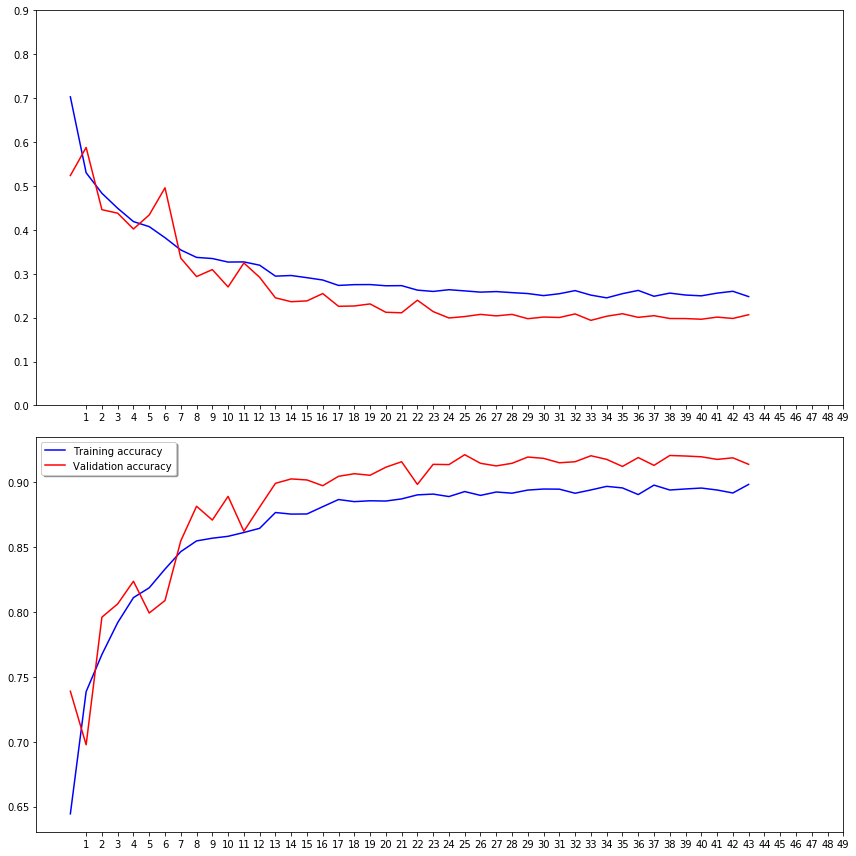

In [51]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['acc'], color='b', label="Training accuracy")
ax2.plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

#### Preparing Testing Data

In [52]:
test_filenames = os.listdir("./Data/test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

#### Creating Testing Generator

In [53]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "./Data/test1/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 12500 images.


#### Predict

In [54]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

As predicted of binary classification result return probability that image likely to be a dog. So we will have threshold 0.5 which mean if predicted value more than 50% it is a dog and under 50% will be a cat.

In [55]:
threshold = 0.5
test_df['probability'] = predict
test_df['category'] = np.where(test_df['probability'] > threshold, 1,0)

#### Visualize result

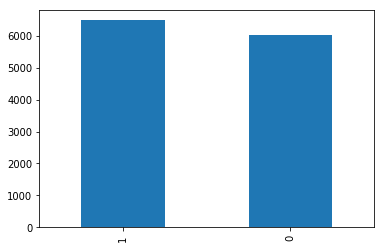

In [56]:
test_df['category'].value_counts().plot.bar()

#### See predicted result with images

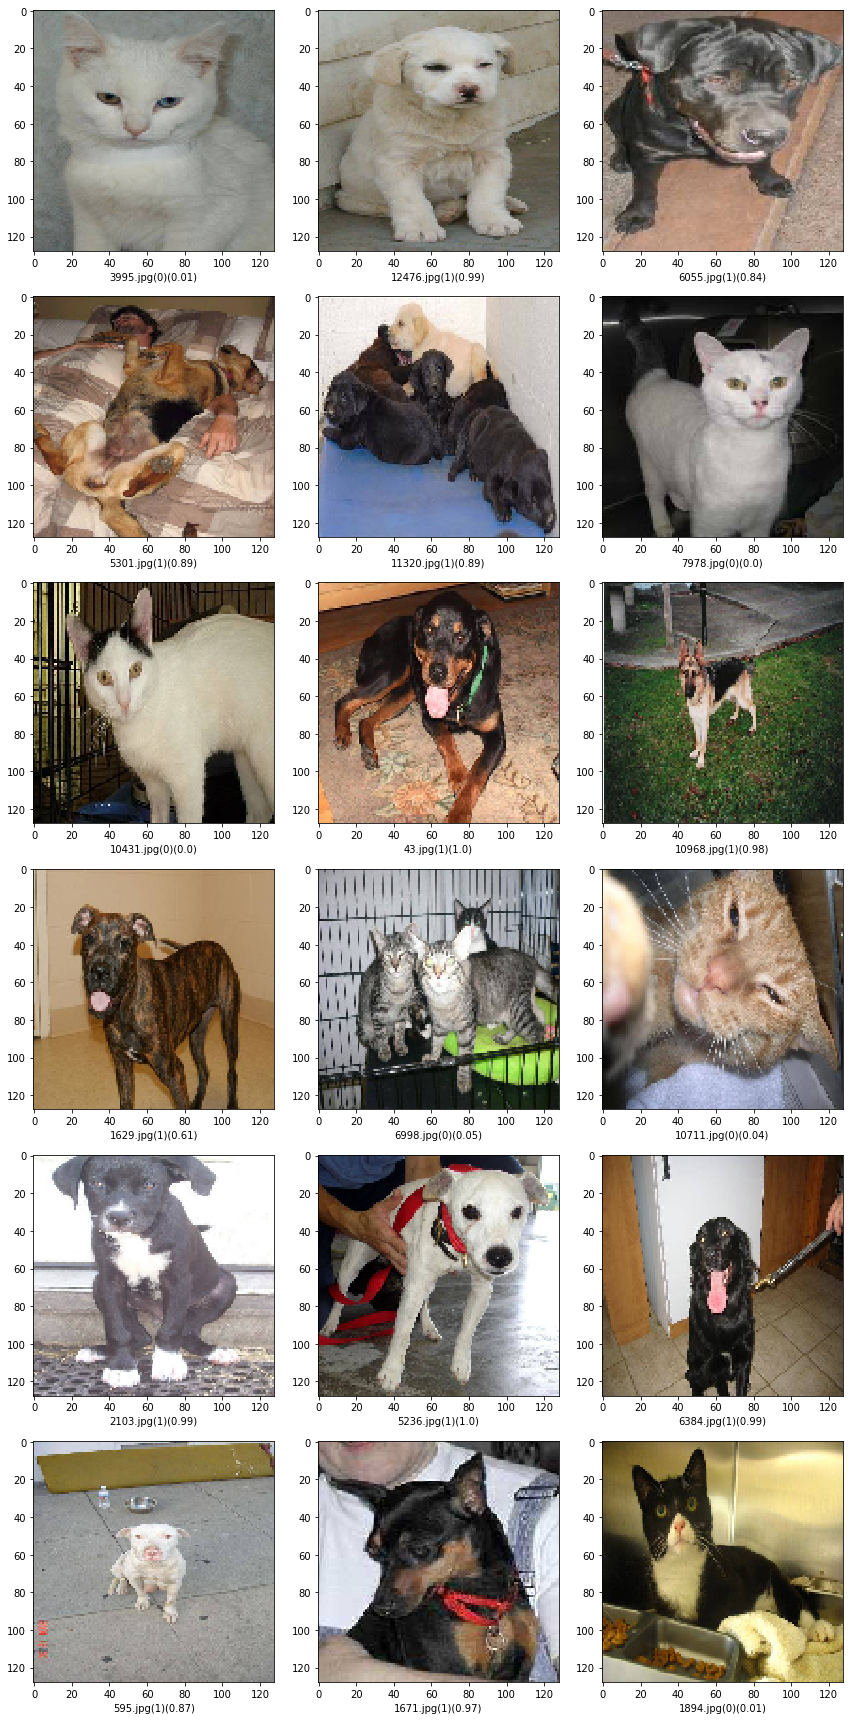

In [58]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    probability = row['probability']
    img = load_img("./Data/test1/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' '(' + "{}".format(round(probability, 2)) + ')')
plt.tight_layout()
plt.show()

#### Submission Data

In [59]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('predicted_data.csv', index=False)